In [2]:
import optuna
import plotly as plot
import torch
from dataset import myDataset
from torch.utils.data import Dataset, DataLoader
from model import BaselineModel
from trainer import Trainer
from optimizer import Lion
import numpy as np
import random
import pandas as pd
import json
import nltk
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


/home/samuel/.conda/envs/hw1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/samuel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/samuel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/samuel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
from textaugment import Translate, EDA, Wordnet
t = Translate(src="en", to="nl")
tweet = 'In the afternoon, John is going to town'
# t.augment()
t = EDA()
t2 = Translate(src="en", to="nl")
t3 = Wordnet()
print(t3.augment(tweet))
# print(t2.augment(tweet))
# print(t.synonym_replacement(tweet))

in the afternoon, john follow going to town


In [5]:
train_embedding = np.load("./elmo_X_train.npy", allow_pickle=True)
train_embedding = np.concatenate(train_embedding, axis=1)
train_embedding = np.transpose(train_embedding, (1,0,2))
train_embedding.shape

(6956, 50, 1024)

In [6]:
train_embedding = np.load("./elmo_y_train.npy", allow_pickle=True)
train_embedding[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
def read_data( root_dir):
    with open(root_dir, "r") as f:
        data = json.load(f)
    df =  pd.DataFrame(data)
    return df
df =read_data("./HW1_dataset/train.json")
df.iloc[:800,:].to_csv("./train.csv", index=False)

In [8]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import nltk
import random
import re                                 
import string
from cleantext import clean            
from nltk.corpus import stopwords     
from nltk.stem import PorterStemmer       
from nltk.tokenize import TweetTokenizer 
from textaugment import Translate, EDA
class myDataset(Dataset):
    def __init__(self, root_dir, vocab, max_seq_length, pad_token, unk_token, kind ="elmo",mode = "train", transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.stopwords = stopwords.words('english')
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.kind = kind
        self.max_seq_length = max_seq_length
        self.w2i = {term:i for i, term in enumerate(vocab)}
        self.i2w = {i:term for i, term in enumerate(vocab)}
        self.data = self.read_data(root_dir)              
        self.tweets = self.preprocess(self.data.tweet)
        if self.mode != "test":
            self.labels = self.data.labels.tolist()
        self.classes = list(pd.read_csv("./HW1_dataset/sample_submission.csv").columns[1:])
        if self.kind =="elmo":
            self.train_embedding = np.load("./elmo_X_train.npy", allow_pickle=True)
            self.train_embedding = np.concatenate(self.train_embedding, axis=1)
            self.train_embedding = np.transpose(self.train_embedding, (1,0,2))
            self.test_embedding = np.load("./elmo_X_test.npy", allow_pickle=True)
            self.test_embedding = np.concatenate(self.test_embedding, axis=1)
            self.test_embedding = np.transpose(self.test_embedding, (1,0,2))
            self.val_embedding = np.load("./elmo_X_val.npy", allow_pickle=True)
            self.val_embedding = np.concatenate(self.val_embedding, axis=1)
            self.val_embedding = np.transpose(self.val_embedding, (1,0,2))
            self.train_label = np.load("./elmo_y_train.npy", allow_pickle=True)
            self.train_label = np.vstack(self.train_label)
            self.val_label = np.load("./elmo_y_val.npy", allow_pickle=True)
            self.val_label = np.vstack(self.val_label)
        elif self.kind == "elmo_new":
            self.train_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_train.npy", allow_pickle=True)
            self.val_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_val.npy", allow_pickle=True)
            self.test_embedding = np.load("./elmo_embedding/new_preprocess_elmo_X_test.npy", allow_pickle=True)
            self.train_label = np.load("./elmo_embedding/new_preprocess_elmo_y_train.npy", allow_pickle=True)
            self.val_label = np.load("./elmo_embedding/new_preprocess_elmo_y_val.npy", allow_pickle=True)
        self.tokenizer = tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    def convert_text_to_input_ids(self, text,pad_to_len):
        words = text[:pad_to_len]
        pad_len = pad_to_len - len(words)
        words.extend([self.pad_token]*pad_len)
        for i in range(len(words)):
            if words[i] not in self.w2i:
                words[i] = self.w2i[self.unk_token]
            else:
                words[i] = self.w2i[words[i]]
        return torch.Tensor(words).long()
    def preprocess(self, tweets):
        def filter_words(x):
            x = re.sub(r'@[A-Za-z0-9_]+', '', x)
            x = re.sub(r'[@#][^\s]*\s*|\s*[@#][^\s]*$', '', x)
            x = re.sub(r'RT[\s]+', '', x)
            x = re.sub(r"@([A-Za-z0-9_]{4,15})", r"@ <user>", x)
            x = re.sub(r'\$', '', x)
            x = re.sub(r'\+', '', x)
            x = re.sub(r'\|', '', x)
            x = re.sub(r'\.\.\.', '', x)
            # x = x.replace("#","<hashtag>")
            x = clean(x,no_emoji=True, lower=True, no_urls =True, no_numbers=True, replace_with_url="", replace_with_number="<NUMBER>")
            return x
        
        # TODO : stemming
        filtered_tweets = tweets.apply(lambda x : filter_words(x))
        return filtered_tweets
    def encode_label(self, label):
        target = torch.zeros(12)
        for l in label:
            idx = self.classes.index(l)
            target[idx] = 1
        return target
    def read_data(self, root_dir):
        with open(root_dir, "r") as f:
            data = json.load(f)
        df =  pd.DataFrame(data)
        if self.mode != "test":
            df["labels"] = df.labels.apply(lambda x : list(x.keys()))
        return df 
    def augment(self, tweet, prob=0.5):
        t = EDA()
        t2 = Translate(src="en", to="nl")
        if random.random() > prob:
            return tweet
        if random.random() > 0.5:
            return t.synonym_replacement(tweet)
        else:
            return t2.augment(tweet)
    def __len__(self):
        if self.kind == "elmo" or self.kind == "elmo_new":
            if self.mode =="train":
                return len(self.train_embedding)
            elif self.mode == "valid":
                return len(self.val_embedding)
            elif self.mode == "test":
                return len(self.test_embedding)
        else:
            return len(self.tweets)
    def __getitem__(self, idx):
        if self.kind == "elmo" or self.kind == "elmo_new":
            if self.mode =="train":
                return torch.tensor(self.train_embedding[idx],dtype=torch.float32), torch.tensor(self.train_label[idx])
            elif self.mode == "valid":
                return  torch.tensor(self.val_embedding[idx],dtype=torch.float32),  torch.tensor(self.val_label[idx])
            elif self.mode == "test":
                return  torch.tensor(self.test_embedding[idx],dtype=torch.float32)
        else:
            tweet = self.tweets[idx]
            if self.transform:
                tweet = self.augment(tweet)
            tweet_token = tweet.apply(lambda x : self.tokenizer.tokenize(x))
            tweet_token = tweet_token.apply(lambda x : [word for word in x if word not in self.stopwords])
            tweet_token = tweet_token.apply(lambda x :self.convert_text_to_input_ids(x, self.max_seq_length) )
            if self.mode == "test":
                return tweet
            else:
                label = self.labels[idx]
                return tweet, self.encode_label(label)

In [9]:
# d = myDataset("./HW1_dataset/train.json", vocab, 50, "<pad>", "<unk>", kind="elmo", mode="train")
# data = DataLoader(d, batch_size=32, shuffle=True)
# for x,y in data:
#     print(x.shape, y.shape)
#     break

In [10]:
import torch
import torch.nn as nn
class BaselineModel(nn.Module):
    def __init__(self, embed_size, pretrain_embeddings, hidden_size, num_layers, num_classes, dropout, is_attention = False, bidirectional = False, freeze = False):
        super(BaselineModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(torch.from_numpy(pretrain_embeddings).float(), freeze=freeze)
        self.lstm = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(2*hidden_size, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.is_attention = is_attention
        self.dropout = nn.Dropout(dropout)
        if is_attention:
            if bidirectional:
                self.attention = nn.Linear(2*hidden_size, 1)
            else:
                self.attention = nn.Linear(hidden_size, 1) 
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        if self.is_attention:
            attention_weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
            x = torch.sum(attention_weights * x, dim=1)
            x = self.dropout(x)
            x = self.fc(x)
        else:
            x = self.dropout(x)
            x = self.fc(x[:, -1, :])
        return x

In [11]:
import torch
import torch.nn as nn
class ELMO(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, num_classes, dropout, is_attention = False, bidirectional = False, freeze = False):
        super(ELMO, self).__init__()
        self.lstm = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional=bidirectional)
        if bidirectional:
            self.fc = nn.Linear(2*hidden_size, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        self.is_attention = is_attention
        self.dropout = nn.Dropout(dropout)
        if is_attention:
            if bidirectional:
                self.attention = nn.Linear(2*hidden_size, 1)
            else:
                self.attention = nn.Linear(hidden_size, 1) 
    def forward(self, x):
        x, _ = self.lstm(x)
        if self.is_attention:
            attention_weights = torch.softmax(self.attention(x), dim=1)  # Attention weights
            x = torch.sum(attention_weights * x, dim=1)
            x = self.dropout(x)
            x = self.fc(torch.relu(x))
        else:
            x = self.dropout(x)
            x = self.fc(torch.relu(x[:, -1, :]))
        return x

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionWeightedAverage(nn.Module):
    def __init__(self, hidden_dim):
        super(AttentionWeightedAverage, self).__init__()
        self.attention = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # Compute attention weights
        attention_weights = F.softmax(self.attention(x), dim=1)
        # Weighted sum of the inputs based on attention weights
        weighted_average = torch.sum(x * attention_weights, dim=1)
        return weighted_average

class KaggleModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim,num_layers, num_classes, dropout,bidirectional):
        super(KaggleModel, self).__init__()
        
        # # Embedding Layer
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Dropout
        self.spatial_dropout = nn.Dropout1d(dropout)
        self.dropout = nn.Dropout(dropout)
        # Bidirectional GRU layers
        self.bi_gru = nn.GRU(embedding_dim, hidden_dim, num_layers, bidirectional=bidirectional, batch_first=True)
        
        
        # Pooling Layers
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Attention Layer
        if bidirectional:
            self.attention = AttentionWeightedAverage(2*hidden_dim)
        else:
            self.attention = AttentionWeightedAverage(hidden_dim)
        
        # Dense Layers
        if bidirectional:
            self.dense1 = nn.Linear(8*hidden_dim, hidden_dim)
            self.dense2 = nn.Linear(hidden_dim, num_classes)
        else:
            self.dense1 = nn.Linear(4*hidden_dim, hidden_dim)
            self.dense2 = nn.Linear(hidden_dim, num_classes)  # Assuming binary classification

    def forward(self, x):
        x = self.dropout(x.permute(0,2,1)).permute((0,2,1))  # Apply dropout
        
        x, _ = self.bi_gru(x)
        # x, _ = self.bi_gru_2(x)
        
        # Concatenate the pooling layers and attention
        max_pool = self.global_max_pool(x.permute(0,2,1)).squeeze(2)
        avg_pool = self.global_avg_pool(x.permute(0,2,1)).squeeze(2)
        attention_pool = self.attention(x)
        last = x[:, -1, :]
        # print(last.shape, max_pool.shape, avg_pool.shape, attention_pool.shape) #torch.Size([128, 256]) torch.Size([128, 256]) torch.Size([128, 256]) torch.Size([128, 256])
        concatenated = torch.cat([last, max_pool, avg_pool, attention_pool], dim=1)
        concatenated = self.dropout(concatenated)
        x = F.relu(self.dense1(concatenated))
        x = self.dense2(x)
        
        return x
# 128x1024 and 640x128
# Assuming vocab size of 10,000, embedding dim of 300 and hidden dim of 128
# model = KaggleModel(10000, 300, 128,12,0.2)
# print(model)


In [13]:
from tqdm import tqdm
from pathlib import Path
import ipdb
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

from tqdm import tqdm
from pathlib import Path
import ipdb
from sklearn.metrics import f1_score
class Trainer(object):
    def __init__(self, model, opt, device, config):
        print(config)
        self.model = model
        self.device = device
        self.opt = opt
        self.train_loss_function = nn.BCEWithLogitsLoss()
        self.test_loss_function = nn.BCEWithLogitsLoss()
        self.classes = list(pd.read_csv("./HW1_dataset/sample_submission.csv").columns[1:])
        self.lambda_ = config["lambda"]
    def train_step(self, train_dataloader):
        train_acc = 0
        train_loss = 0
        self.model.train()
        for x,y in train_dataloader:
            x,y = x.to(self.device), y.to(self.device)
            pred = self.model(x)
            
            loss = self.train_loss_function(pred, y)
            l2_reg = torch.tensor(0.).to(self.device)
            for param in self.model.parameters():
                l2_reg += torch.norm(param)
            loss += self.lambda_ * l2_reg
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()
            train_loss += loss.item()
            
            y_prob = torch.sigmoid(pred)>0.5
            true_labels = y.cpu().detach().numpy()
            predicted_labels = y_prob.int().cpu().detach().numpy()
            # Compute the macro F1 score
            macro_f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
            train_acc += macro_f1
        return train_loss/len(train_dataloader), train_acc/len(train_dataloader)

    def val_step(self, val_dataloader): 
        test_acc = 0
        test_loss = 0
        self.model.eval()
        with torch.inference_mode():
            for x,y in val_dataloader:
                x,y = x.to(self.device), y.to(self.device)
                pred_y = self.model(x)
                loss = self.test_loss_function(pred_y,y) 
                test_loss += loss.item()
                y_prob = torch.sigmoid(pred_y)>0.5
                true_labels = y.cpu().detach().numpy()
                predicted_labels = y_prob.int().cpu().detach().numpy()
                macro_f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
                test_acc += macro_f1
        return test_loss/len(val_dataloader), test_acc/len(val_dataloader)
    def test_step(self, test_dataloader): 
        self.model.eval()
        all_data =np.zeros((len(test_dataloader),12))
        with torch.inference_mode():
            for i,x in enumerate(test_dataloader):
                x = x.to(self.device)
                pred_y = self.model(x)
                y_prob = (torch.sigmoid(pred_y)>0.5).int().cpu().detach().numpy()
                all_data[i] = np.expand_dims(y_prob,0)
        df =pd.DataFrame(all_data, columns= self.classes)
        return df
    def train(self, epochs, train_dataloader, val_dataloader, patience, model_name, scheduler):
        last_loss = float("inf")
        best_val_f1 =float("-inf")
        cur = 0
        results ={
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[]
        }
        for epoch in range(epochs):
            train_loss, train_acc = self.train_step(train_dataloader)
            test_loss, test_acc = self.val_step(val_dataloader)
            if scheduler:    
                scheduler.step(test_loss)
            if (epoch+1)%5 == 0:
                if test_loss > last_loss:
                    cur += 1
                    print('trigger times:', cur)
                    if cur >= patience:
                        print("early stop !")
                        return results
                else:
                    cur = 0
            last_loss = test_loss
            print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"val_loss: {test_loss:.4f} | "
            f"val_acc: {test_acc:.4f}"
            )

            results["train_loss"].append(train_loss)
            results["train_acc"].append(train_acc)
            results["val_loss"].append(test_loss)
            results["val_acc"].append(test_acc)
            
            if (epoch+1)%10 == 0:
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"model_{epoch+1}.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
            if best_val_f1<test_acc:
                best_val_f1 = test_acc
                MODEL_PATH = Path("models/"+model_name)
                MODEL_PATH.mkdir(parents=True, 
                                exist_ok=True
                )

                MODEL_NAME = f"best_model.pth"
                MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
                print(f"Saving model to: {MODEL_SAVE_PATH}")
                torch.save(obj=self.model.state_dict(),
                        f=MODEL_SAVE_PATH)
        # MODEL_PATH = Path("models/"+model_name)
        # MODEL_PATH.mkdir(parents=True, exist_ok=True)
        # # torch.save(obj=self.model.state_dict(),
        # #                 f=MODEL_PATH/f"best_model_E{epoch}.pth")
        return results

In [14]:
config = {
    "lr":5e-4,
    "batch_size": 128,
    "num_epochs": 100,
    "num_layers": 1,
    "hidden_size": 448,
    "dropout": 0.3,
    "is_attention": True,
    "bidirectional": True,
    # "freeze": False,
    # "embedding_table_lr" : 11e-5,
    "patience": 1000,
    "model_name": "elmo_kaggle",
    "lambda": 4.5e-5,
    
}

In [15]:
best_params: {'lr': 0.0004979853152256414, 'batch_size': 128, 'num_layers': 1, 'hidden_size': 448, 'dropout': 0.5, 'is_attention': True, 'bidirectional': True, 'freeze': True, 'lambda_': 4.5685958276211076e-05}
best_value: 0.5837540272478066

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data_path = "./HW1_dataset/train.json"
val_data_path = "./HW1_dataset/val.json"
test_data_path = "./HW1_dataset/test.json"
vocab = np.load("./glove/vocab.npy")
embs = np.load("./glove/embeddings.100d.npy")
train_dataset = myDataset(train_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>',kind="elmo_new",  mode ="train")
val_dataset = myDataset(val_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>', kind="elmo_new", mode ="valid")
test_dataset = myDataset(test_data_path, vocab, max_seq_length= 55,pad_token='<pad>', unk_token='<unk>', kind="elmo_new", mode ="test")
train_dataloader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["batch_size"], shuffle=False)
test_daloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [17]:
# model = BaselineModel(embed_size=100, pretrain_embeddings=embs, hidden_size=config["hidden_size"], num_layers=config["num_layers"], num_classes=12,
#                     dropout=config["dropout"], is_attention=config["is_attention"], bidirectional=config["bidirectional"], freeze = config["freeze"])
# model =ELMO(embed_size=1024, hidden_size=config["hidden_size"], num_layers=config["num_layers"], num_classes=12,
#             dropout=config["dropout"], is_attention = config["is_attention"], bidirectional = config["bidirectional"], freeze = config["freeze"])
model = KaggleModel(embedding_dim=1024, hidden_dim=config["hidden_size"], num_layers=config["num_layers"], num_classes=12, dropout=config["dropout"],bidirectional=config["bidirectional"])
model.to(device)
EPOCHs = config["num_epochs"]
opt = Lion(model.parameters(), lr=config["lr"])
trainer = Trainer(model,opt=opt, device = device, config=config)
res = trainer.train(epochs= EPOCHs, train_dataloader=train_dataloader, val_dataloader=val_dataloader, patience=config["patience"], model_name=config['model_name'], scheduler=None)

{'lr': 0.0005, 'batch_size': 128, 'num_epochs': 100, 'num_layers': 1, 'hidden_size': 448, 'dropout': 0.3, 'is_attention': True, 'bidirectional': True, 'freeze': False, 'embedding_table_lr': 0.00011, 'patience': 1000, 'model_name': 'elmo_kaggle', 'lambda': 4.5e-05}
Epoch: 1 | train_loss: 0.3091 | train_acc: 0.0259 | val_loss: 0.2612 | val_acc: 0.0632
Saving model to: models/elmo_kaggle/best_model.pth
Epoch: 2 | train_loss: 0.2518 | train_acc: 0.1055 | val_loss: 0.2317 | val_acc: 0.1443
Saving model to: models/elmo_kaggle/best_model.pth
Epoch: 3 | train_loss: 0.2131 | train_acc: 0.2471 | val_loss: 0.1909 | val_acc: 0.3145
Saving model to: models/elmo_kaggle/best_model.pth
Epoch: 4 | train_loss: 0.1862 | train_acc: 0.3740 | val_loss: 0.1764 | val_acc: 0.3970
Saving model to: models/elmo_kaggle/best_model.pth
Epoch: 5 | train_loss: 0.1626 | train_acc: 0.4645 | val_loss: 0.1720 | val_acc: 0.4487
Saving model to: models/elmo_kaggle/best_model.pth
Epoch: 6 | train_loss: 0.1398 | train_acc: 0.

In [18]:
trainer.model.load_state_dict(torch.load("./models/elmo_kaggle/best_model.pth"))
trainer.model.eval()
trainer.model.to(device)
trainer.test_step(test_daloader).to_csv("./submission.csv", index_label="index")

0.5723541896668596

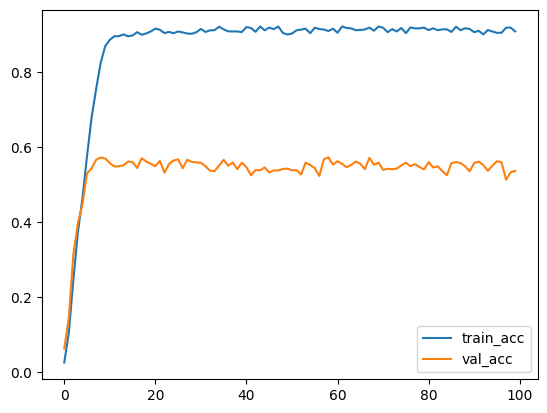

In [19]:
res = pd.DataFrame(res)
res[['train_acc','val_acc']].plot()
#ylim=(0.4,0.55)
res['val_acc'].max()

<Axes: >

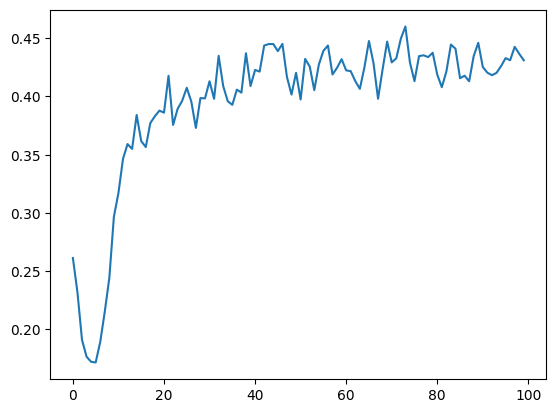

In [20]:
res['val_loss'].plot()